# Block Encoding Verification

This notebook verifies the various block encoding, whose code are given in this directory. The matrix input is assumed to be a sparse matrix. We verify the following quantum functions for block encoding:
1. Prepare and Select for Pauli decomposition of the matrix. The Select block is implemented with Gray code technique.
2. Banded diagonal block encoding, according to Ref.

For both block encoding we construct a symmetric and non-symmetric versions. The former is needed for the Chebyshev LCU solver, and the latter for the QSVT solver.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from classical_functions_rr import *
from quantum_functions_rr import *
from scipy import sparse

from classiq import *
from classiq.applications.chemistry.op_utils import qubit_op_to_pauli_terms

np.random.seed(53)

We define a generic function for verifying block-encoding qfuncs:

In [2]:
def get_be_state(rhs_vec, be_qfunc, block_size, data_size):
    """
    Apply a block-encoding qfunc to an initial state and return the post-selected output.

    Parameters
    ----------
    rhs_vec : list[real]
        Amplitudes of the initial data state |\psi>. Length must be 2**data_size.
    be_qfunc : qfunc
        A Qmod qfunc with signature be_qfunc(block: QNum, data: QNum) that applies
        the block-encoding for the matrix A/s.
    block_size : int
        Number of qubits in the block variable.
    data_size : int
        Number of qubits in the data variable.

    Returns
    -------
    array
        The post-selected data variable state equal to (A/s)|\psi>, obtained
        by projecting the block register onto 0 after applying the block encoding.
    """

    execution_preferences = ExecutionPreferences(
        num_shots=1,
        backend_preferences=ClassiqBackendPreferences(
            backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
        ),
    )

    @qfunc
    def main(
        data: Output[QNum[data_size]],
        block: Output[QNum[block_size]],
    ):

        allocate(block)
        prepare_amplitudes(rhs_vec, 0.0, data)
        be_qfunc(block, data)

    qprog = synthesize(main, preferences=Preferences(timeout_seconds=2000))
    with ExecutionSession(qprog, execution_preferences) as es:
        results = es.sample()
    resulting_state = get_projected_state_vector(results, "data", {"block": 0.0})
    return resulting_state

In [3]:
def verify_by_plot(mat, rhs, be_factor, qsol):
    # Plot quantum solution vs expected ine
    expected_sol = (mat @ rhs) / be_factor
    plt.plot(expected_sol, "o")
    ext_idx = np.argmax(np.abs(expected_sol))
    correct_sign = np.sign(expected_sol[ext_idx]) / np.sign(qsol[ext_idx])
    qsol *= correct_sign
    plt.plot(qsol, ".")

    return expected_sol

Test a specific matrix

In [4]:
import pathlib

path = (
    pathlib.Path(__file__).parent.resolve()
    if "__file__" in locals()
    else pathlib.Path(".")
)

In [5]:
mat_name = "cavity-pc-4x4-i100_mat"
matfile = "matrices/" + mat_name + ".npz"
mat_raw_scr = sparse.load_npz(path / matfile)

## Pauli block-encoding (non-Hermitian)

In [6]:
rval = mat_raw_scr.data
col = mat_raw_scr.indices
rowstt = mat_raw_scr.indptr
nr = mat_raw_scr.shape[0]

data_size = int(np.log2(nr))

# decompose to Paulis
paulis_list, transform_matrix = initialize_paulis_from_csr(
    rowstt, col, data_size, to_symmetrize=False
)
qubit_op = eval_pauli_op(paulis_list, transform_matrix, rval)
qubit_op.compress(1e-12)
hamiltonian = qubit_op_to_pauli_terms(qubit_op)

# Calculate scaling factor and block size
be_scaling_factor = sum([np.abs(term.coefficient) for term in hamiltonian.terms])
block_size = max(1, (len(hamiltonian.terms) - 1).bit_length())

rand_bvec = 1 - 2 * np.random.rand(2**data_size)
rand_bvec = (rand_bvec / np.linalg.norm(rand_bvec)).tolist()
hamiltonian = hamiltonian * (1 / be_scaling_factor)


# Define block encoding function
@qfunc
def block_encode_pauli(block: QNum, data: QNum):
    lcu_paulis_graycode(hamiltonian.terms, data, block)


qsol = get_be_state(rand_bvec, block_encode_pauli, block_size, data_size)

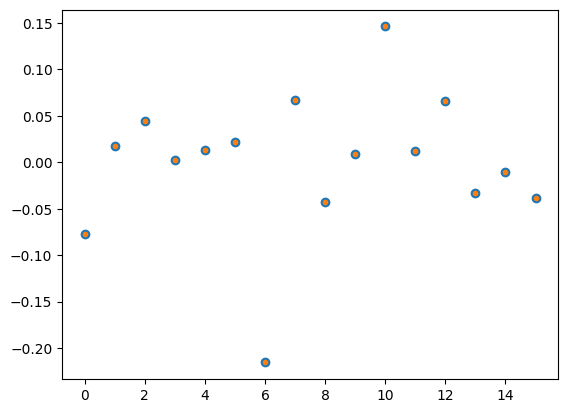

In [7]:
expected_sol = verify_by_plot(mat_raw_scr, rand_bvec, be_scaling_factor, qsol)
assert np.linalg.norm(qsol - expected_sol) < 1e-10

## Pauli block-encoding (Hermitian)

In [8]:
rval = mat_raw_scr.data
col = mat_raw_scr.indices
rowstt = mat_raw_scr.indptr
nr = mat_raw_scr.shape[0]

data_size = int(np.log2(nr))

# decompose to Paulis
paulis_list, transform_matrix = initialize_paulis_from_csr(
    rowstt, col, data_size, to_symmetrize=True
)
data_size += 1  # in the symmetric case the data size is increased by 1

qubit_op = eval_pauli_op(paulis_list, transform_matrix, rval)
qubit_op.compress(1e-12)
hamiltonian = qubit_op_to_pauli_terms(qubit_op)

# Calculate scaling factor and block size
be_scaling_factor = sum([np.abs(term.coefficient) for term in hamiltonian.terms])
block_size = max(1, (len(hamiltonian.terms) - 1).bit_length())

rand_bvec = 1 - 2 * np.random.rand(2**data_size)
rand_bvec = (rand_bvec / np.linalg.norm(rand_bvec)).tolist()
hamiltonian = hamiltonian * (1 / be_scaling_factor)


# Define block encoding function
@qfunc
def block_encode_pauli(block: QNum, data: QNum):
    lcu_paulis_graycode(hamiltonian.terms, data, block)


qsol = get_be_state(rand_bvec, block_encode_pauli, block_size, data_size)

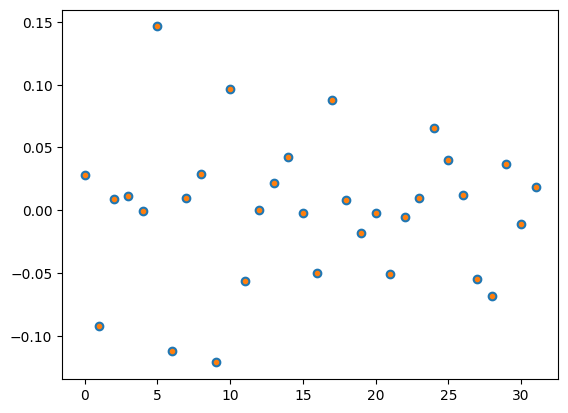

In [9]:
mat_raw = mat_raw_scr.toarray()
mat_sym = np.block(
    [
        [np.zeros([nr, nr]), np.transpose(mat_raw)],
        [mat_raw, np.zeros([nr, nr])],
    ]
)
expected_sol = verify_by_plot(mat_sym, rand_bvec, be_scaling_factor, qsol)
assert np.linalg.norm(qsol - expected_sol) < 1e-10

## Banded block-encoding (non-Hermitian)

In [10]:
# Get diagonal properties
offsets, diags, diags_maxima, prepare_norm = get_be_banded_data(mat_raw_scr)

data_size = int(np.ceil(np.log2(len(diags[0]))))
s_size = int(np.ceil(np.log2(len(offsets))))

# Calculate scaling factor and block size
block_size = s_size + 1
be_scaling_factor = prepare_norm


# Define block encoding function
@qfunc
def block_encode_banded_matrix(block: QNum, data: QNum):
    block_encode_banded(
        offsets=offsets, diags=diags, prep_diag=diags_maxima, block=block, data=data
    )


rand_bvec = 1 - 2 * np.random.rand(2**data_size)
rand_bvec = (rand_bvec / np.linalg.norm(rand_bvec)).tolist()


qsol = get_be_state(rand_bvec, block_encode_banded_matrix, block_size, data_size)

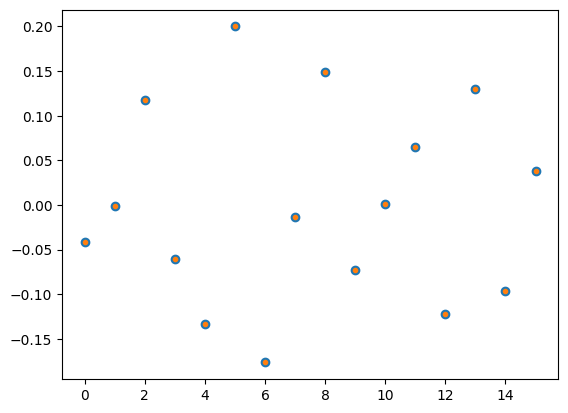

In [11]:
expected_sol = verify_by_plot(mat_raw_scr, rand_bvec, be_scaling_factor, qsol)
assert np.linalg.norm(qsol - expected_sol) < 1e-10